# Redes neurais recorrentes

<b>Sumário</b>

- Revisão de redes neurais profundas (DFF)
- Exemplo de DFF com Iris dataset
- Conjunto de treino, de teste e de validação!
- Otimizando o número de épocas para evitar overfitting
- Problema do desaparecimento do gradiente
- Entendendo o que são redes neurais recorrentes
- Fazendo seu próprio gerador de textos usando Lusíadas de Luís Vaz de Camões
- Análise de sentimentos com redes neurais recorrentes
- Estudo de caso: Avaliando reviews de filmes (IMDB)


## Revisão das aulas passadas (DFF)

Seja $(X, y)$ um conjunto de dados onde $X \in M_{m \times n}(\mathbb{R})$ são as variáveis preditoras e $y \in M_{m\times 1}({\mathbb{R}}^s)$ a variável de interesse. Podemos escrever $X = (X_1, \ldots, X_m)$ com $X_i = (x_{i1}, \ldots, x_{in}) \in {\mathbb{R}}^n$.

Uma rede neural DFF (Deep Feed Forward) de p camadas escondidas é tal que a predição $\hat{y} \in M_{m\times 1}({\mathbb{R}}^s)$ é dada por

$$\hat{y} = \phi_n(W_nC_{n-1} + B_n),$$

onde $C_0 = X$ e $C_{k} = \phi_k(W_kC_{k-1} + B_k)$. As funções $\phi_k$ são chamadas de funções de ativação, $W_k$ é chamado de $k$-ésima camada escondida e $B_k$ de k-ésimo bias.

A perda de entropia cruzada é definida por

$$E(y, \hat{y}) = -y_1\log(\hat{y}_1) - \cdots -y_s\log(\hat{y}_s)$$

O objetivo é minimizar a perda de entropia cruzada variando os coeficientes de $W_k$ e de $B_k$. Podemos pensar então $E$ como uma função dos coeficientes de $W_k$ e $B_k$ e nosso objetivo é

$$
\begin{array}{ll}
\text{minimizar} & E(W, B) = E(W_1, \ldots, W_n, B_1, \ldots, B_n) \\
(W, B) = (W_1, \ldots, W_n, B_1, \ldots, B_n) &
\end{array}
$$

Existem várias formas iterativas de minimizar $E$, uma delas é a técnica de Gradiente Descendente Estocástico (SGD) que em cada etapa (época) faz

$$(W, B)_{t+1} = (W, B)_t + \alpha \nabla E\left((W, B)_{t}\right)$$

O coeficiente $\alpha \in {\mathbb{R}}$ é chamado de taxa de aprendizado (learning rate). A medida que a rede vai se ajustando, o gradiente vai se aproximando de zero. Este comportamento é um problema, uma vez que os pesos tendem a levar um maior tempo para se ajustarem.

## Exemplo

2/2 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.94      1.00      0.97        15
           2       1.00      0.91      0.95        11

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



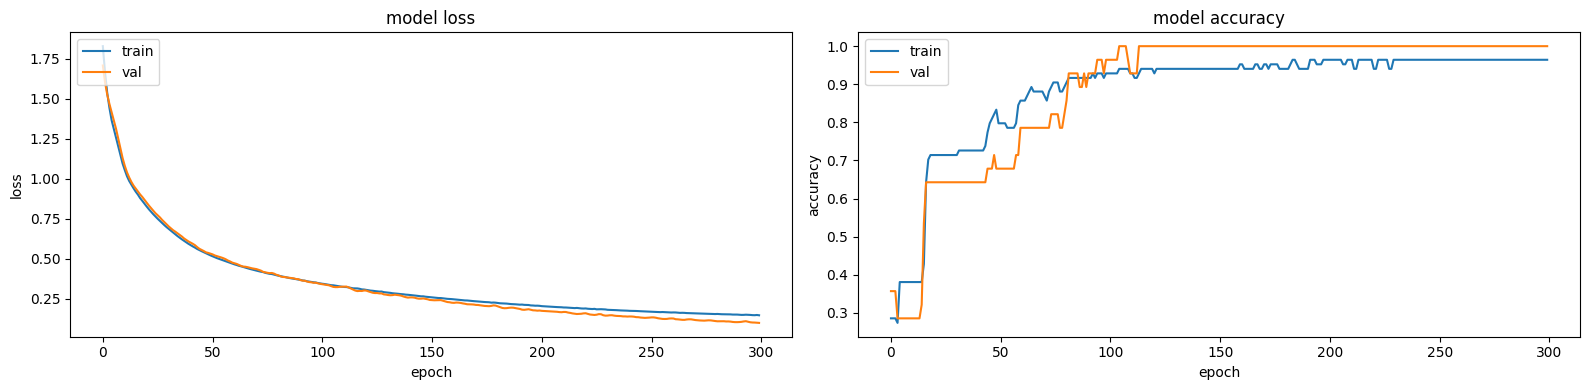

In [ ]:
from sklearn.datasets import load_iris
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


iris = load_iris()
X = iris.data # Matriz 150 x 4
y = iris.target # Matriz 150 x 1 real (precisa converter)
y = to_categorical(y) # Matriz 150 x 1 R3 ([1,0,0], [0,1,0], [0,0,1])

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

model = Sequential()
model.add(Input(shape=(4,))) # n=4
model.add(
    Dense(50), # W1 Matriz 4x5 (50 pode ser escolhido)
)
model.add(
    Activation('relu'), # phi 1
)
model.add(
    Dense(3), # W2 Matriz 5x3 (3 poder ser valor de s)
)
model.add(
    Activation('softmax'), # phi 2 (ativação final em classificação)
)

model.compile(
    'adam', # otimizador (pode ser gradiente estocástico decrescente)
    loss="categorical_crossentropy", # função de perda para calculo dos pesos
    metrics=["accuracy"]) # métrica de avaliação do modelo

history = model.fit(
    X_train, y_train,
    batch_size = 32, # número de amostras por otimização
    epochs = 300, # número de otimizações
    validation_data = (X_val, y_val), verbose = 0
)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_pred, y_test))

plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

# Redes neurais recorrentes RNR

Observe que no caso de DFF's a k-ésima camada oculta recebe informações apenas da camada anterior. No caso de redes neurais recorrentes, a k-ésima camada oculta também recebe informações de camadas anteriores a camada k-1.

Para ilustrar pensemos numa rede neurais DFF com três camadas:

$$C_0 = X$$
$$C_1 = \phi_1(W^1_1C_0 + B_1)$$
$$C_2 = \phi_2(W^1_2C_1 + B_2)$$
$$\hat{y} = C_3 = \phi_3(W^1_3C_2 + B_3)$$

Acontece que para cada $X_i$ toda a propagação é feita. Logo vamos pensar que $C_{ik}$ é a k-ésima camada da propagação para $X_i$. Reescrevendo:

$$C_{i0} = X_i$$
$$C_{i1} = \phi_1(W^1_1C_{i0} + B_1)$$
$$C_{i2} = \phi_2(W^1_2C_{i1} + B_2)$$
$$\hat{y}_i = C_{i3} = \phi_3(W^1_3C_{i2} + B_3)$$

A figura abaixo é uma representação da i-ésima propagação:

<center>
<img width="250px" src="https://github.com/leandrocl2005/Curso-basico-de-Python-para-cientistas-de-dados/blob/master/assets/foward_propagation.png?raw=true">
</center>

Observe, por exemplo, que $\hat{y}_2$ recebe apenas informações de $X_2$. Vamos alterar a rede para que $\hat{y_2}$ também receba informações de $X_1$. As equações agora ficam:

$$C_{i0} = X_i$$
$$C_{i1} = \phi_1(W^1_1C_{i0} + B_1)$$
$$C_{i2} = \phi_2(W^1_2C_{i1} + V^1_2C_{(i-1)1} + B_2)$$
$$\hat{y}_i = C_{i3} = \phi_3(W^1_3C_{i2} + V^1_3C_{(i-1)2} + B_3)$$

A figura abaixo é uma representação da i-ésima, (i+1)-ésima e (i+2)-ésima propagação da rede neural recorrente.

<center>
<img width="250px" src="https://github.com/leandrocl2005/Curso-basico-de-Python-para-cientistas-de-dados/blob/master/assets/rnr.jpg?raw=true">
</center>

Essas redes são úteis para séries temporais e processamento natural de linguagem. Na ilustração acima a propagação $i$ só depende de $X_i$ e das saídas das camadas na propagação $i-1$, no entando, a idéia se generaliza em relação a adição de camadas de propagação ainda anteriores a $i-1$.

- https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/
- https://matheusfacure.github.io/2017/09/12/rnn/

- https://en.wikipedia.org/wiki/Vanishing_gradient_problem

- https://www.youtube.com/watch?v=AsNTP8Kwu80

## Gerando textos com Redes neurais recorrentes

- https://github.com/PacktPublishing/Deep-Learning-with-Keras/tree/master

In [ ]:
import numpy as np
import urllib.request
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.models import Sequential
import requests  # the lib that handles the url stuff

import io
with io.open("lusiadas.txt", "r", encoding="ascii", errors='ignore') as my_file:
    my_unicode_string = my_file.read()
    lines = []
    for line in my_unicode_string:
        line = line.replace('\n', " ").lower()
        if len(line) != 0:
          lines.append(line)
    text = "".join(lines)

chars = set([c for c in text])
nb_chars = len(chars)
char2index = dict((c,i) for i, c in enumerate(chars))
index2char = dict((i,c) for i, c in enumerate(chars))

SEQLEN = 10
STEP = 1

input_chars = []
label_chars = []
for i in range(0, len(text)-SEQLEN, STEP):
  input_chars.append(text[i:i + SEQLEN])
  label_chars.append(text[i + SEQLEN])

X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=bool)
y = np.zeros((len(input_chars), nb_chars), dtype=bool)
for i, input_char in enumerate(input_chars):
  for j, ch in enumerate(input_char):
    X[i, j, char2index[ch]] = 1
  y[i, char2index[label_chars[i]]] = 1

In [ ]:
HIDDEN_SIZE = 128
BATCH_SIZE = 128
NUM_ITERATIONS = 25
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

model = Sequential()
model.add(
    SimpleRNN(
        HIDDEN_SIZE,
        return_sequences=False,
        input_shape=(SEQLEN, nb_chars)
    )
)
model.add(Dense(nb_chars))
model.add(Activation("Softmax"))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

# We train the model in batches and test output generated at each step
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print("Iteration #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # testing model
    # randomly choose a row from input_chars, then use it to
    # generate text from model for next 100 chars
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]
    print("Generating from seed: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):
        Xtest = np.zeros((1, SEQLEN, nb_chars))
        for i, ch in enumerate(test_chars):
            Xtest[0, i, char2index[ch]] = 1
        pred = model.predict(Xtest, verbose=0)[0]
        ypred = index2char[np.argmax(pred)]
        print(ypred, end="")
        # move forward with test_chars + ypred
        test_chars = test_chars[1:] + ypred
    print()

Iteration #: 0
2401/2401 [==============================] - 29s 10ms/step - loss: 2.1760
Generating from seed: ros dos ar
ros dos aras de e cora de e cora de e cora de e cora de e cora de e cora de e cora de e cora de e cora de e co
Iteration #: 1
2401/2401 [==============================] - 24s 10ms/step - loss: 2.0073
Generating from seed: erga comps
erga compses o mar corte e a dera e terra e mar com terra e mar com terra e mar com terra e mar com terra e ma
Iteration #: 2
2401/2401 [==============================] - 25s 10ms/step - loss: 1.9354
Generating from seed: cidades e 
cidades e com o se enterra e terra e terra e terra e terra e terra e terra e terra e terra e terra e terra e t
Iteration #: 3
2401/2401 [==============================] - 29s 12ms/step - loss: 1.8793
Generating from seed: ano, sem s
ano, sem se aligando a sente de alia a terra de aliante a terra de aliante a terra de aliante a terra de alian
Iteration #: 4
2401/2401 [==============================] - 33s 14ms

# Exercício

Faça o mesmo, agora indexando palavras ao invés de caracteres. Quais problemas encontrou? Como resolveu?

## Análise de sentimento com redes neurais recorrentes

- https://www.geeksforgeeks.org/sentiment-analysis-with-an-recurrent-neural-networks-rnn/

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    SimpleRNN,
    Dense,
    Embedding
)
from tensorflow.keras.preprocessing import sequence

# 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative)
from tensorflow.keras.datasets import imdb
import numpy as np

# 5000 palavras mais frequentes
num_words = 5000

# palavras são mapeadas pela frequência
# zero significa espaço
# x_train[0] -> [1,2,1,0,600,2,...]
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# dicionário word -> freq
word_idx = imdb.get_word_index()
# inverte o dicionário: freq -> word
word_idx = {i: word for word, i in word_idx.items()}

# vamos imprimir o primeiro review
print([word_idx[i] for i in x_train[0]])

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'and', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 'they'

In [ ]:
print("Máximo de palavras num review: ", len(max((x_train+x_test), key=len)))
print("Mínimo de palavras num review: ", len(min((x_train+x_test), key=len)))

Máximo de palavras num review:  2697
Mínimo de palavras num review:  70


In [ ]:
# manter todos os reviews de mesmo tamanho (400)
x_train = sequence.pad_sequences(x_train, maxlen=400)
x_test = sequence.pad_sequences(x_test, maxlen=400)

# mantendo 64 reviews para validação
x_valid, y_valid = x_train[:64], y_train[:64]
x_train_, y_train_ = x_train[64:], y_train[64:]

RNN_model = Sequential()
RNN_model.add(
    Embedding(
      num_words, # número máximo de palavras no dataset
      32, # tamanho do vetor para rede https://www.nature.com/articles/s41598-020-71450-8
      input_length=400)) # tamanho do vetor de reviews
RNN_model.add(
    SimpleRNN(128,
      activation='tanh',
      return_sequences=False # se 2xSimpleRNN : True
))
RNN_model.add(Dense(1, activation='sigmoid'))

RNN_model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the model
history = RNN_model.fit(x_train_, y_train_,
  batch_size=64,
  epochs=10,
  verbose=1,
  validation_data=(x_valid, y_valid))

Epoch 1/10
390/390 [==============================] - 223s 566ms/step - loss: 0.6327 - accuracy: 0.6149 - val_loss: 0.4651 - val_accuracy: 0.7969
Epoch 2/10
390/390 [==============================] - 190s 487ms/step - loss: 0.5124 - accuracy: 0.7449 - val_loss: 0.4969 - val_accuracy: 0.7969
Epoch 3/10
390/390 [==============================] - 180s 461ms/step - loss: 0.4675 - accuracy: 0.7887 - val_loss: 0.4697 - val_accuracy: 0.7969
Epoch 4/10
390/390 [==============================] - 176s 451ms/step - loss: 0.4871 - accuracy: 0.7624 - val_loss: 0.6556 - val_accuracy: 0.6406
Epoch 5/10
390/390 [==============================] - 175s 449ms/step - loss: 0.4845 - accuracy: 0.7627 - val_loss: 0.6341 - val_accuracy: 0.5938
Epoch 6/10
390/390 [==============================] - 174s 445ms/step - loss: 0.4859 - accuracy: 0.7672 - val_loss: 0.5917 - val_accuracy: 0.7344
Epoch 7/10
390/390 [==============================] - 172s 440ms/step - loss: 0.3971 - accuracy: 0.8167 - val_loss: 0.6319 -

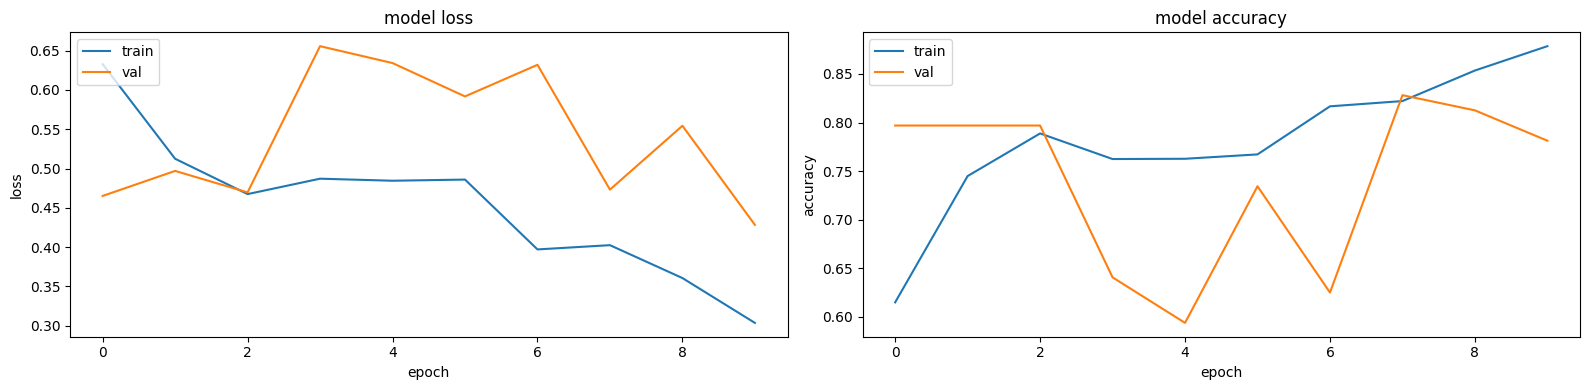

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# RNN_model.predict(x_test)
[print(i.shape, i.dtype) for i in RNN_model.inputs]
[print(o.shape, o.dtype) for o in RNN_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in RNN_model.layers]

(None, 400) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
embedding (None, 400) float32
simple_rnn_1 (None, 400, 32) float32
dense_1 (None, 128) float32


[None, None, None]

In [ ]:
Xt = np.asarray(x_test).astype(np.float32)
RNN_model.predict(Xt)

782/782 [==============================] - 28s 36ms/step


array([[0.04952207],
       [0.9785744 ],
       [0.05854248],
       ...,
       [0.17611748],
       [0.05288098],
       [0.6579517 ]], dtype=float32)

LSTM é um tipo de rede neural recorrente que mantém informações de propagações bem anteriores à propagação atual. Em geral costumam ser melhores que as redes neurais recorrentes simples pois evitam o problema de desaparecimento do gradiente. Nas próximas aulas veremos um pouco mais sobre essa rede.

## Exercício:

Tente mudar o código anterior trocando a SimpleRNN por uma LSTM.

Se tiver dificuldade consulte o tutorial: https://victorzhou.com/blog/keras-rnn-tutorial/

### Referências

- https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://towardsdatascience.com/lstm-gradients-b3996e6a0296